In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hr_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_heart_rate.csv')
hr_df['Time'] = pd.to_datetime(hr_df['Time'])


In [3]:
def get_mean_min_vals(group):
    mean_minute_vals = group.resample('1Min', on='Time')['Value'].mean() 
    return mean_minute_vals.to_frame()
    
hr_per_min_df = hr_df.groupby('Id').apply(get_mean_min_vals)
print(hr_per_min_df)

                                     Value
Id         Time                           
2022484408 2016-04-01 07:54:00   99.600000
           2016-04-01 07:55:00  110.111111
           2016-04-01 07:56:00   92.555556
           2016-04-01 07:57:00   90.400000
           2016-04-01 07:58:00   97.875000
...                                    ...
8877689391 2016-05-12 14:40:00   56.222222
           2016-05-12 14:41:00   57.857143
           2016-05-12 14:42:00   56.000000
           2016-05-12 14:43:00   57.500000
           2016-05-12 14:44:00   55.333333

[772967 rows x 1 columns]


In [4]:
# combine with minutes activity intensity data:
mins_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_activity_minutes.csv')
# removing not needed data fields:
mins_df = mins_df.drop(columns=['Calories', 'METs', 'Steps'])
# rename index for merging:
hr_per_min_df.index.names = ['Id', 'ActivityMinute']
# convert datetime field to datetime data type:
mins_df['ActivityMinute'] = pd.to_datetime(mins_df['ActivityMinute'])
mins_df = mins_df.set_index(['Id', 'ActivityMinute'])

hr_intensity_df = pd.merge(hr_per_min_df, mins_df, left_index=True, right_index=True)
hr_intensity_df = hr_intensity_df.reset_index().set_index('Id')
hr_intensity_df.head()

,ActivityMinute,Value,Intensity
Id,,,
2022484408,2016-04-01 07:54:00,99.600000,1
2022484408,2016-04-01 07:55:00,110.111111,1
2022484408,2016-04-01 07:56:00,92.555556,1
2022484408,2016-04-01 07:57:00,90.400000,0
2022484408,2016-04-01 07:58:00,97.875000,1


In [5]:
hr_intensity_df.isna().sum()

ActivityMinute         0
Value             293706
Intensity              0
dtype: int64

In [6]:
# drop null cases - non existant hr values don't provide use for hr indicators
hr_intensity_df = hr_intensity_df.dropna()
hr_intensity_df.isna().sum()

ActivityMinute    0
Value             0
Intensity         0
dtype: int64

In [7]:
specific_id = 2022484408

In [8]:
last_30_days_of_id_data = hr_intensity_df[hr_intensity_df.index == specific_id]['ActivityMinute'].dt.date.values
last_30_days_of_id_data = sorted(set(last_30_days_of_id_data), reverse=True)[:30]
last_30_days_of_id_data

[datetime.date(2016, 5, 12),
 datetime.date(2016, 5, 11),
 datetime.date(2016, 5, 10),
 datetime.date(2016, 5, 9),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 7),
 datetime.date(2016, 5, 6),
 datetime.date(2016, 5, 5),
 datetime.date(2016, 5, 4),
 datetime.date(2016, 5, 3),
 datetime.date(2016, 5, 2),
 datetime.date(2016, 5, 1),
 datetime.date(2016, 4, 30),
 datetime.date(2016, 4, 29),
 datetime.date(2016, 4, 28),
 datetime.date(2016, 4, 27),
 datetime.date(2016, 4, 26),
 datetime.date(2016, 4, 25),
 datetime.date(2016, 4, 24),
 datetime.date(2016, 4, 23),
 datetime.date(2016, 4, 22),
 datetime.date(2016, 4, 21),
 datetime.date(2016, 4, 20),
 datetime.date(2016, 4, 19),
 datetime.date(2016, 4, 18),
 datetime.date(2016, 4, 17),
 datetime.date(2016, 4, 16),
 datetime.date(2016, 4, 15),
 datetime.date(2016, 4, 14),
 datetime.date(2016, 4, 13)]

In [9]:
hr_intensity_df = hr_intensity_df.reset_index()
id_last_30_days_recent_values_df = hr_intensity_df[(hr_intensity_df['Id'] == specific_id) & 
                                                   (hr_intensity_df['ActivityMinute'].dt.date.isin(last_30_days_of_id_data))]

id_last_30_days_recent_values_df

,Id,ActivityMinute,Value,Intensity
8446,2022484408,2016-04-13 07:01:00,93.666667,1
8447,2022484408,2016-04-13 07:02:00,65.875000,1
8448,2022484408,2016-04-13 07:03:00,55.833333,0
8449,2022484408,2016-04-13 07:04:00,57.428571,0
8450,2022484408,2016-04-13 07:05:00,59.571429,0
...,...,...,...,...
28756,2022484408,2016-05-12 14:55:00,60.166667,0
28757,2022484408,2016-05-12 14:56:00,61.800000,1
28758,2022484408,2016-05-12 14:57:00,64.714286,1
28759,2022484408,2016-05-12 14:58:00,68.500000,1


In [10]:
# get previous and next values in aim to remove random intensity drops
id_last_30_days_recent_values_df['prev_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(1)
id_last_30_days_recent_values_df['prev2_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(2)
id_last_30_days_recent_values_df['prev3_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(3)

id_last_30_days_recent_values_df['next_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(-1)
id_last_30_days_recent_values_df['next2_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(-2)
id_last_30_days_recent_values_df['next3_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(-3)
id_last_30_days_recent_values_df.head()

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_61707/1123457518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_last_30_days_recent_values_df['prev_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(1)
/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_61707/1123457518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_last_30_days_recent_values_df['prev2_intensity'] = id_last_30_days_recent_values_df['Intensity'].shift(2)
/var/folders/jn/tpkp2dnx08592l_y59z9_f3

,Id,ActivityMinute,Value,Intensity,prev_intensity,prev2_intensity,prev3_intensity,next_intensity,next2_intensity,next3_intensity
8446,2022484408,2016-04-13 07:01:00,93.666667,1,NaN,NaN,NaN,1.0,0.0,0.0
8447,2022484408,2016-04-13 07:02:00,65.875000,1,1.0,NaN,NaN,0.0,0.0,0.0
8448,2022484408,2016-04-13 07:03:00,55.833333,0,1.0,1.0,NaN,0.0,0.0,0.0
8449,2022484408,2016-04-13 07:04:00,57.428571,0,0.0,1.0,1.0,0.0,0.0,0.0
8450,2022484408,2016-04-13 07:05:00,59.571429,0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
# median_resting_hr - (median to avoid outliers):
average_resting_hr = np.median(id_last_30_days_recent_values_df[(id_last_30_days_recent_values_df['Intensity'] == 0) & 
                (id_last_30_days_recent_values_df['prev_intensity'] == 0) & 
                (id_last_30_days_recent_values_df['prev2_intensity'] == 0) &
                (id_last_30_days_recent_values_df['prev3_intensity'] == 0) &
                (id_last_30_days_recent_values_df['next_intensity'] == 0) &
                (id_last_30_days_recent_values_df['next2_intensity'] == 0) &
                (id_last_30_days_recent_values_df['next3_intensity'] == 0)
                ]['Value'])
average_resting_hr

66.5

In [12]:
average_light_activity_hr = np.median(id_last_30_days_recent_values_df[(id_last_30_days_recent_values_df['Intensity'] == 1) & 
                (id_last_30_days_recent_values_df['prev_intensity'] == 1) & 
                (id_last_30_days_recent_values_df['prev2_intensity'] == 1) &
                (id_last_30_days_recent_values_df['prev3_intensity'] == 1) &
                (id_last_30_days_recent_values_df['next_intensity'] == 1) &
                (id_last_30_days_recent_values_df['next2_intensity'] == 1) &
                (id_last_30_days_recent_values_df['next3_intensity'] == 1)
                ]['Value'])

average_moderate_activity_hr = np.median(id_last_30_days_recent_values_df[(id_last_30_days_recent_values_df['Intensity'] == 2) & 
                (id_last_30_days_recent_values_df['prev_intensity'] == 2) & 
                (id_last_30_days_recent_values_df['prev2_intensity'] == 2) &
                (id_last_30_days_recent_values_df['prev3_intensity'] == 2) &
                (id_last_30_days_recent_values_df['next_intensity'] == 2) &
                (id_last_30_days_recent_values_df['next2_intensity'] == 2) &
                (id_last_30_days_recent_values_df['next3_intensity'] == 2)
                ]['Value'])

average_high_activity_hr = np.median(id_last_30_days_recent_values_df[(id_last_30_days_recent_values_df['Intensity'] == 3) & 
                (id_last_30_days_recent_values_df['prev_intensity'] == 3) & 
                (id_last_30_days_recent_values_df['prev2_intensity'] == 3) &
                (id_last_30_days_recent_values_df['prev3_intensity'] == 3) &
                (id_last_30_days_recent_values_df['next_intensity'] == 3) &
                (id_last_30_days_recent_values_df['next2_intensity'] == 3) &
                (id_last_30_days_recent_values_df['next3_intensity'] == 3)
                ]['Value'])

In [13]:
# getting daily median hr for other intensity levels of activity
def get_median_light_activity_hr(group):
    median_light_activity_hr = group[(group['Intensity'] == 1) & (group['prev_intensity'] == 1) & (group['next_intensity'] == 1) &
                                    (group['prev2_intensity'] == 1) &
                                    (group['prev3_intensity'] == 1) &
                                    (group['next2_intensity'] == 1) &
                                    (group['next3_intensity'] == 1)
                                    ]['Value'].median()
    return median_light_activity_hr

daily_av_light_activity_hr = id_last_30_days_recent_values_df.groupby(['Id', id_last_30_days_recent_values_df['ActivityMinute'].dt.date]).apply(get_median_light_activity_hr)


def get_median_moderate_activity_hr(group):
    median_moderate_activity_hr = group[(group['Intensity'] == 2) & (group['prev_intensity'] == 2) & (group['next_intensity'] == 2) &
                                    (group['prev2_intensity'] == 2) &
                                    (group['prev3_intensity'] == 2) &
                                    (group['next2_intensity'] == 2) &
                                    (group['next3_intensity'] == 2)
                                    ]['Value'].median()
    return median_moderate_activity_hr

daily_av_moderate_activity_hr = id_last_30_days_recent_values_df.groupby(['Id', id_last_30_days_recent_values_df['ActivityMinute'].dt.date]).apply(get_median_moderate_activity_hr)


def get_median_high_activity_hr(group):
    median_high_activity_hr = group[(group['Intensity'] == 3) & (group['prev_intensity'] == 3) & (group['next_intensity'] == 3) &
                                    (group['prev2_intensity'] == 3) &
                                    (group['prev3_intensity'] == 3) &
                                    (group['next2_intensity'] == 3) &
                                    (group['next3_intensity'] == 3) 
                                    ]['Value'].median()
    return median_high_activity_hr

daily_av_high_activity_hr = id_last_30_days_recent_values_df.groupby(['Id', id_last_30_days_recent_values_df['ActivityMinute'].dt.date]).apply(get_median_high_activity_hr)


In [14]:
#TODO get the average daily max hr instead of max heart rate!
average_daily_max_hr = np.median(id_last_30_days_recent_values_df.groupby([hr_intensity_df['ActivityMinute'].dt.date]).apply(lambda group: group['Value'].max()).values)


In [15]:
average_heart_rate_reserve = average_daily_max_hr - average_resting_hr
average_heart_rate_reserve

78.22727272727275

# Karvonen Method for heart rate training zone:

In [16]:
sixty_percent = (0.6*average_heart_rate_reserve) + average_resting_hr
seventy_percent = (0.7*average_heart_rate_reserve) + average_resting_hr 
eighty_percent = (0.8*average_heart_rate_reserve) + average_resting_hr 
ninety_percent = (0.9*average_heart_rate_reserve) + average_resting_hr 

light_intensity_target_zone = (sixty_percent, seventy_percent)
moderate_intensity_target_zone = (seventy_percent, eighty_percent)
high_intensity_target_zone = (eighty_percent, ninety_percent)

print(light_intensity_target_zone, moderate_intensity_target_zone, high_intensity_target_zone)

(113.43636363636364, 121.25909090909093) (121.25909090909093, 129.0818181818182) (129.0818181818182, 136.90454545454548)


In [17]:
average_light_activity_hr, average_moderate_activity_hr, average_high_activity_hr

(92.0, 105.73214285714286, 127.55555555555556)

In [18]:

daily_av_light_activity_hr.name = 'Daily Average Light Intensity Hr'
daily_av_light_activity_hr_df = daily_av_light_activity_hr.to_frame()

daily_av_moderate_activity_hr.name = 'Daily Average Moderate Intensity Hr'
daily_av_moderate_activity_hr_df = daily_av_moderate_activity_hr.to_frame()
median_hrs_df = pd.merge(daily_av_light_activity_hr_df, daily_av_moderate_activity_hr_df, left_index=True, right_index=True)

daily_av_high_activity_hr.name = 'Daily Average High Intensity Hr'
daily_av_high_activity_hr_df = daily_av_high_activity_hr.to_frame()
median_hrs_df = pd.merge(median_hrs_df, daily_av_high_activity_hr_df, left_index=True, right_index=True)

median_hrs_df.head()



Daily Average Light Intensity Hr  \
Id         ActivityMinute                                     
2022484408 2016-04-13                             95.333333   
           2016-04-14                             85.400000   
           2016-04-15                             93.000000   
           2016-04-16                             85.375000   
           2016-04-17                             92.309524   

                           Daily Average Moderate Intensity Hr  \
Id         ActivityMinute                                        
2022484408 2016-04-13                                      NaN   
           2016-04-14                                      NaN   
           2016-04-15                                      NaN   
           2016-04-16                                      NaN   
           2016-04-17                                    106.0   

                           Daily Average High Intensity Hr  
Id         ActivityMinute                                   
2022484408 2016-04-13                           121.616667  
           2016-04-14                            93.322222  
           2016-04-15                           136.666667  
           2016-04-16                           109.669643  
           2016-04-17                           153.526786

In [19]:
median_hrs_df

Daily Average Light Intensity Hr  \
Id         ActivityMinute                                     
2022484408 2016-04-13                             95.333333   
           2016-04-14                             85.400000   
           2016-04-15                             93.000000   
           2016-04-16                             85.375000   
           2016-04-17                             92.309524   
           2016-04-18                             93.833333   
           2016-04-19                             98.500000   
           2016-04-20                             94.111111   
           2016-04-21                             92.000000   
           2016-04-22                             95.857143   
           2016-04-23                             83.125000   
           2016-04-24                             93.928571   
           2016-04-25                             92.116071   
           2016-04-26                             98.333333   
           2016-04-27                             95.957143   
           2016-04-28                             78.118056   
           2016-04-29                             97.107143   
           2016-04-30                             87.222222   
           2016-05-01                             90.375000   
           2016-05-02                             92.030303   
           2016-05-03                             96.264286   
           2016-05-04                             94.375000   
           2016-05-05                             90.375641   
           2016-05-06                             92.625000   
           2016-05-07                             88.875000   
           2016-05-08                             86.000000   
           2016-05-09                             93.984127   
           2016-05-10                             90.041667   
           2016-05-11                             93.750000   
           2016-05-12                             99.444444   

                           Daily Average Moderate Intensity Hr  \
Id         ActivityMinute                                        
2022484408 2016-04-13                                      NaN   
           2016-04-14                                      NaN   
           2016-04-15                                      NaN   
           2016-04-16                                      NaN   
           2016-04-17                               106.000000   
           2016-04-18                                      NaN   
           2016-04-19                                      NaN   
           2016-04-20                               108.818182   
           2016-04-21                               111.625000   
           2016-04-22                                      NaN   
           2016-04-23                                      NaN   
           2016-04-24                                95.575000   
           2016-04-25                                      NaN   
           2016-04-26                               108.800000   
           2016-04-27                                      NaN   
           2016-04-28                                92.812500   
           2016-04-29                                      NaN   
           2016-04-30                                      NaN   
           2016-05-01                               105.803571   
           2016-05-02                                      NaN   
           2016-05-03                                      NaN   
           2016-05-04                               104.125000   
           2016-05-05                                      NaN   
           2016-05-06                                      NaN   
           2016-05-07                                      NaN   
           2016-05-08                                      NaN   
           2016-05-09                               105.600000   
           2016-05-10                                84.666667   
           2016-05-11         

In [20]:
median_hrs_df = median_hrs_df.reset_index().set_index('Id')
median_hrs_df.head()

,ActivityMinute,Daily Average Light Intensity Hr,Daily Average Moderate Intensity Hr,Daily Average High Intensity Hr
Id,,,,
2022484408,2016-04-13,95.333333,NaN,121.616667
2022484408,2016-04-14,85.400000,NaN,93.322222
2022484408,2016-04-15,93.000000,NaN,136.666667
2022484408,2016-04-16,85.375000,NaN,109.669643
2022484408,2016-04-17,92.309524,106.0,153.526786


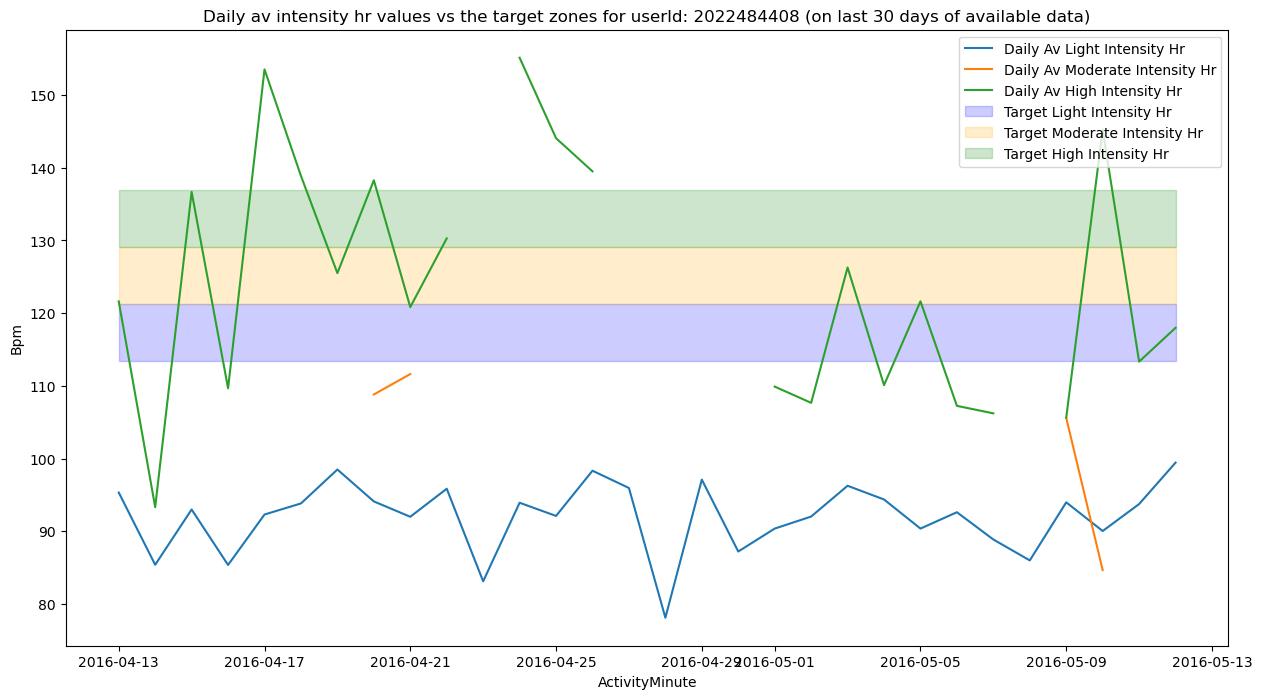

In [21]:
# daily average hr for different intensity lines:
median_hrs_df[['ActivityMinute', 'Daily Average Light Intensity Hr', 'Daily Average Moderate Intensity Hr', 'Daily Average High Intensity Hr']].set_index('ActivityMinute').plot(figsize=(15, 8))
plt.title(f"Daily av intensity hr values vs the target zones for userId: {specific_id} (on last 30 days of available data)")

# average lines
# plt.axhline(y=average_light_acitivty_hr, color = 'b', linestyle = '-') 
# plt.axhline(y=average_moderate_activity_hr, color = 'orange', linestyle = '-') 
# plt.axhline(y=average_high_activity_hr, color = 'g', linestyle = '-') 


# target zones
plt.fill_between(x=median_hrs_df['ActivityMinute'], y1=light_intensity_target_zone[0], y2=light_intensity_target_zone[1], alpha=0.2, color='b')
plt.fill_between(x=median_hrs_df['ActivityMinute'], y1=moderate_intensity_target_zone[0], y2=moderate_intensity_target_zone[1], alpha=0.2, color='orange')
plt.fill_between(x=median_hrs_df['ActivityMinute'], y1=high_intensity_target_zone[0], y2=high_intensity_target_zone[1], alpha=0.2, color='g')
plt.legend(['Daily Av Light Intensity Hr', 'Daily Av Moderate Intensity Hr', 'Daily Av High Intensity Hr', 'Target Light Intensity Hr', 'Target Moderate Intensity Hr', 'Target High Intensity Hr'])

# average_light_acitivty_hr, average_moderate_activity_hr, average_high_activity_hr
plt.ylabel('Bpm')
plt.show()

In [22]:
# recommendation:
average_light_activity_hr, light_intensity_target_zone[0], light_intensity_target_zone[1]

(92.0, 113.43636363636364, 121.25909090909093)

In [23]:
# recommend the target zones and show the current averages